In [1]:
import json
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

def read_json(json_file):
    with open(json_file) as js:
        json_data = json.load(js)
    return json_data

def json2frame(item, item2):
    item1 = pd.read_json(item)
    item2 = pd.read_json(item2)
    item = pd.concat([item1, item2], ignore_index=True)
    return item

In [2]:
best1 = 'sample_dataset_1/bestshots.json'
best2 = '22-03-07/bestshots.json'
best = json2frame(best1, best2)
#best = read_json(best_1)
item1 = 'sample_dataset_1/itemsets.json'
item2 = '22-03-07/items.json'
item = json2frame(item1, item2)
# item = read_json(item1)

# category = 'sample_dataset_2/category_infos.json'
# category2 = '22-03-07/categories.json'

products1 = 'sample_dataset_2/products_meta.json'
products2 = '22-03-07/products.json'

products = read_json(products1)
products2 = read_json(products2)
products.update(products2)

In [3]:
class EDA:
    
    def EDA_WORD(self,best, item, products):

        prod_tags = pd.DataFrame(products).T.reset_index(drop=True)[['_id', 'tags', 'name', 'images']]

        item.rename(columns={'_id' : 'id', 'enterpriseId' : 'enterprise_id'}, inplace=True)
        best_item = pd.merge(best, item, on=['id', 'enterprise_id', 'projectId'])


        def get_productId(items_list):
            new_list = []
            for item in items_list:
                new_list.append(item['productId'])
            return new_list

        best_item['product_id'] = best_item['items'].apply(get_productId)
        best_item.drop(columns=['items'], inplace=True)

        def prod_name(categories):
            x = categories.copy()
            w = []
            for i in x:
                for z in prod_tags['_id']:
                    if z in i:
                        b = prod_tags.iloc[np.where(prod_tags['_id'] == z)]
                        w.append(b['name'].iloc[0])
            return w

        best_item['name'] = best_item['product_id'].apply(prod_name)

        best_item = best_item[['enterprise_id', 'awesome_score', 'product_id', 'name', 'top_style', 'projectId']]


#         def flatten_data(best_item):

#             best_items = best_item.join(best_item['product_id'].apply(lambda x: pd.Series(x)).stack().reset_index(1, name='items').drop('level_1', axis=1))
#             best_items.drop(columns=['product_id', 'name'],inplace=True)

#             return best_items

#         def flatten_data2(names, best_items):
#             names = names.copy()
#             best_items = best_items.copy()
#             x = names['name'].apply(lambda x: pd.Series(x)).stack().reset_index(1, name='names').drop('level_1', axis=1)
#             df = pd.concat([best_items, x], axis=1)
            
#             return df

#         flatten_data = flatten_data(best_item)

#         flatten = flatten_data2(best_item,flatten_data)

#         prod_df = pd.merge(flatten, prod_tags, left_on='items', right_on='_id').drop(['_id'], axis=1)
#         prod_df = pd.merge(prod_df, prod_df['items'].value_counts().reset_index(),
#                            left_on='items', right_on = 'index').rename(columns = {'items': 'product_id','items_y':'use_count'}).drop(['index'], axis=1)
#         prod_df.drop(columns=['name', 'use_count'], inplace=True)

        return  best_item
    
    
    def EDA_CF(self,best, item, products):
        
        item.rename(columns={'_id' : 'id', 'enterpriseId' : 'enterprise_id'}, inplace=True)
        best_item = pd.merge(best, item, on=['id', 'enterprise_id', 'projectId'])


        def get_productId(items_list):
            new_list = []
            for item in items_list:
                new_list.append(item['productId'])
            return new_list

        best_item['items'] = best_item['items'].apply(get_productId)

        best_item['top3_style'] = best_item['style_predictions'].apply(lambda x: sorted([(name, score) for name, score in x.items()], key=lambda x: x[1], reverse=True)[:3])
        # top 3 style 점수, 이름 가져오기
        best_item['top3_style'] = best_item['top3_style'].apply(lambda x: [name for name, score, in x])
        # top3_style 이름만 가져오기
        best_item['top3_style'] = best_item['top3_style'].apply(lambda x: ' '.join(x))
        # 리스트 제거 

        items_stack = pd.DataFrame(best_item['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)

        products_df = pd.merge(best_item[['enterprise_id', 'top3_style', 'top_style', 'projectId', 'awesome_score']]
                           .reset_index(),
                           items_stack.reset_index(),
                           on='index').drop(['index'],axis=1).rename(columns = {0:'product_id'})

        prod_tags = pd.DataFrame(products).T.reset_index(drop=True)[['_id', 'tags', 'name', 'images']]

        prod_df = pd.merge(products_df, prod_tags, left_on='product_id', right_on='_id').drop(['_id'], axis=1)
        prod_df = pd.merge(prod_df, prod_df['product_id'].value_counts().reset_index(),
                           left_on='product_id', right_on = 'index').rename(columns = {'product_id_x': 'product_id','product_id_y':'use_count'}).drop(['index'], axis=1)

        return prod_df

In [4]:
x = EDA()
best_item= x.EDA_WORD(best, item, products)

In [5]:
x = EDA()
prod = x.EDA_CF(best, item, products)

C:\Users\jumpx\AppData\Local\Temp\ipykernel_11608\1634565333.py:83: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(best_item['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


사용자가 선택한 아이템 : 화이트 정사각 LED 방등 화이트


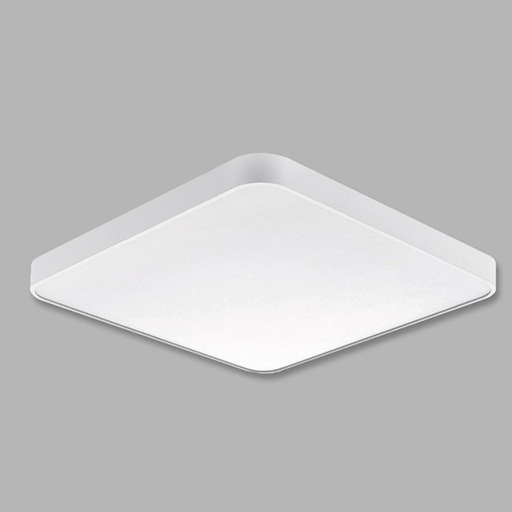

추천 아이템 Top10


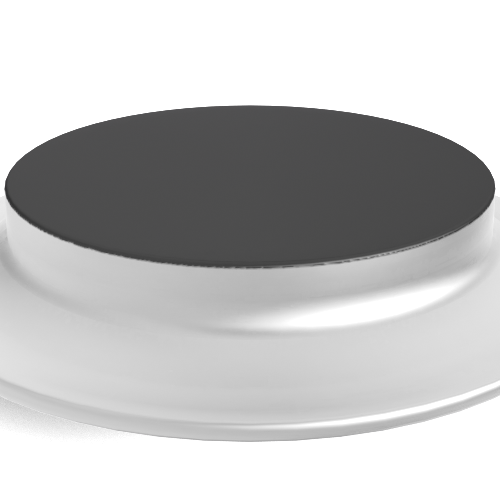

1순위 추천 아이템 : LED 다운라이트 2인치 5W 크롬 (주광색)
------------------------------------------------------------


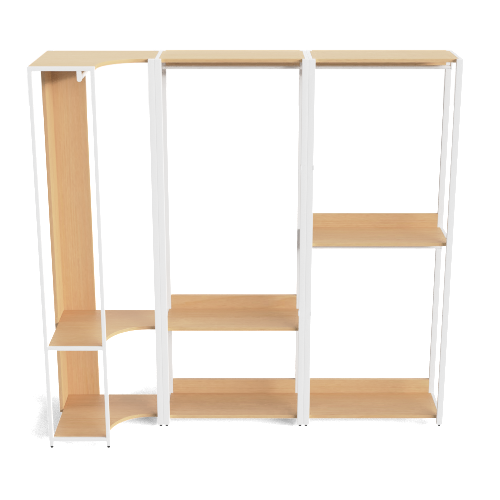

2순위 추천 아이템 : 아이언 행거형 철제 드레스룸 2200 A세트 (화이트오크)
------------------------------------------------------------


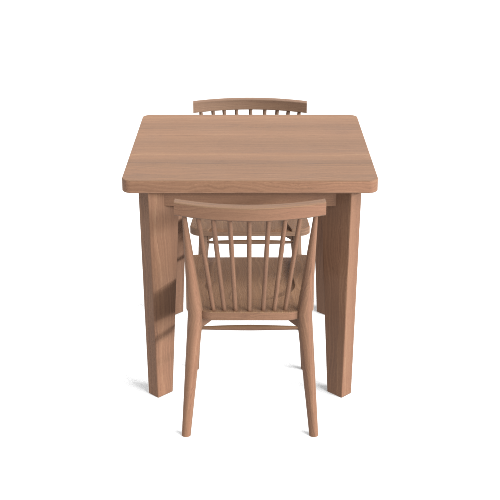

3순위 추천 아이템 : 베르메 고무나무 2인 원목식탁세트 2colors (식탁) 내추럴
------------------------------------------------------------


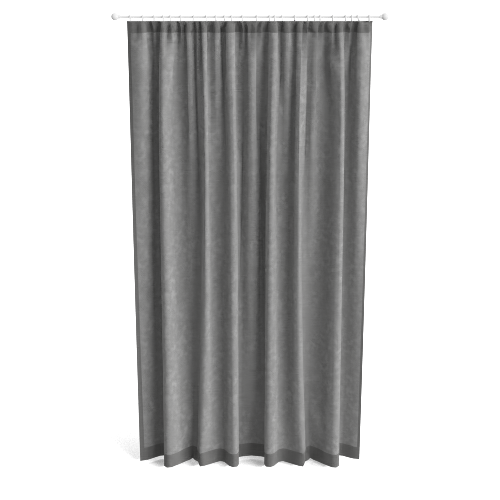

4순위 추천 아이템 : 피톤치드 오즈 거실커튼 긴창커튼 (오즈 차콜)
------------------------------------------------------------


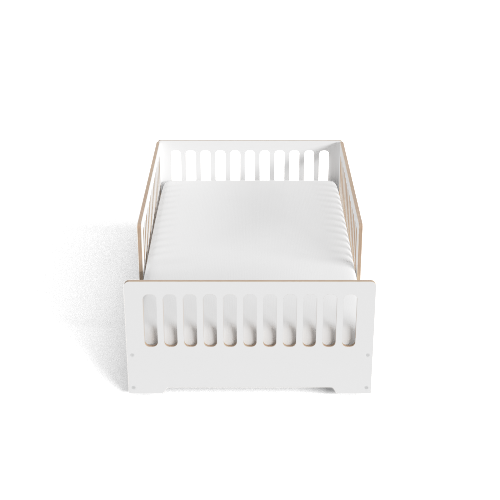

5순위 추천 아이템 : 안나침대(SS) (화이트)
------------------------------------------------------------


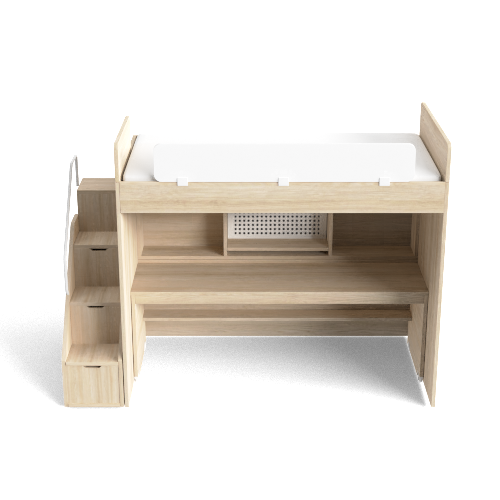

6순위 추천 아이템 : 이큐 책상형 수납계단 벙커침대 EQBN213 (화이트)
------------------------------------------------------------


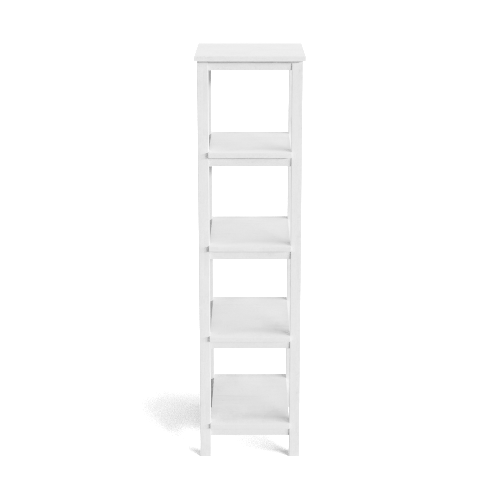

7순위 추천 아이템 : 고무나무 원목 사다리 다용도 수납선반 3colors (화이트)
------------------------------------------------------------


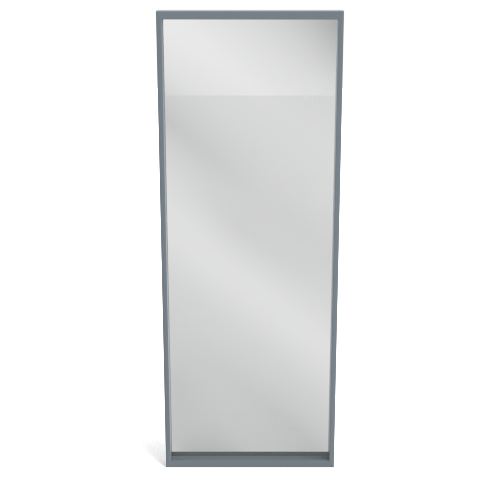

8순위 추천 아이템 : 비산 파손방지 강화 안전 대형 전신거울 600 (그레이)
------------------------------------------------------------


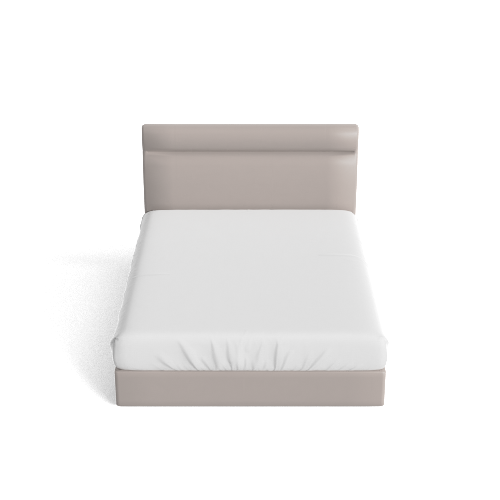

9순위 추천 아이템 : 호텔식 투매트침대 (본넬양면) (크림화이트)
------------------------------------------------------------


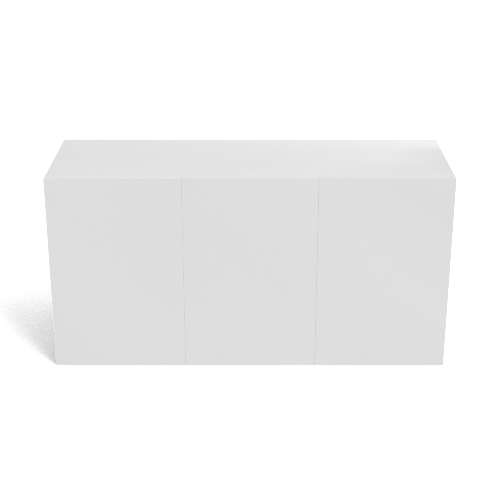

10순위 추천 아이템 : 스킨 거실장시리즈 1200 높은 거실장 2colors 화이트
------------------------------------------------------------


[('LED 다운라이트 2인치 5W 크롬 (주광색)', 0.8303239941596985),
 ('아이언 행거형 철제 드레스룸 2200 A세트 (화이트오크)', 0.8136696219444275),
 ('베르메 고무나무 2인 원목식탁세트 2colors (식탁) 내추럴', 0.8082571625709534),
 ('피톤치드 오즈 거실커튼 긴창커튼 (오즈 차콜)', 0.7983375787734985),
 ('안나침대(SS) (화이트)', 0.790885329246521),
 ('이큐 책상형 수납계단 벙커침대 EQBN213 (화이트)', 0.7858164310455322),
 ('고무나무 원목 사다리 다용도 수납선반 3colors (화이트)', 0.7743486166000366),
 ('비산 파손방지 강화 안전 대형 전신거울 600 (그레이)', 0.7720587253570557),
 ('호텔식 투매트침대 (본넬양면) (크림화이트)', 0.7699869871139526),
 ('스킨 거실장시리즈 1200 높은 거실장 2colors 화이트', 0.7656853199005127)]

In [14]:
# 1개만 선택할 시에 유사한 이미지 추천
# 2개 이상 -> 전문가 데이터를 활용해 유사도 및 cf-svd

def recommend_word(best_item, prod, item_name):
    
    if len(item_name) == 1:
        
        enterprise = prod[prod['name']==item_name[0]]['enterprise_id'].values[0]
        best_items = best_item[best_item['enterprise_id'] == str(enterprise)]
        
        best_items = best_item[['projectId', 'product_id', 'name']]

        def build_model(best_item):
            sentence = best_item['name'].values.tolist()
            embedding_model = Word2Vec(sentence,
                                       vector_size=20,
                                       window=5,
                                       min_count=1,
                                       workers=4,
                                       epochs=200,
                                       sg=1)
            return embedding_model

        def get_rec_result(df, prod, model, search_word_list, topn = 10):
            result = model.wv.most_similar(positive=search_word_list, topn=topn)

            for search_word in search_word_list:
                print(f'사용자가 선택한 아이템 : {search_word}')
                search_images = prod[prod['name'] == search_word]['images'].values.tolist()[0]
                try:
                    res = requests.get(search_images[0])
                    img = Image.open(BytesIO(res.content))
                    display(img)
                except:
                    print('이미지 없음\n')

            print("="*80)
            print(f"추천 아이템 Top{topn}")
            print("="*80)

            # 추천된 이미지들 보여주기
            for i, (name, _) in enumerate(result):   
                    images = prod[prod['name'] == name]['images'].values.tolist()[0]
                    try:
                        res = requests.get(images[0])
                        img = Image.open(BytesIO(res.content))
                        display(img)
                    except:
                        print('이미지 없음\n')
                    print(f'{i+1}순위 추천 아이템 : {name}')
                    print("-"*60)

            return result

        emb_model_b = build_model(best_items)

        search_word_list = item_name

        return get_rec_result(best_items, prod, emb_model_b, search_word_list, topn=10)
    
    else:
        enterprise_list = []
        for i in item_name:
            enterprise_list.append(prod[prod['name']==i]['enterprise_id'].values[0])
        
        prod = prod[prod['enterprise_id'] == enterprise_list[0]]
        prod.reset_index(drop=True, inplace=True)
        
        search_userId = 'user'
        matrix = prod.pivot_table('awesome_score', index='projectId', columns='name').fillna(0).round().astype(int)
        matrix.loc['user'] = 0
        for i in item_name:
            x = matrix.loc['user'].keys() == i
            x = x.astype(int)
            matrix.loc['user'] = x
        
        def get_rmse(R, P, Q, non_zeros):
            error = 0
            full_pred_matrix = np.dot(P, Q.T)

            x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
            y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
            R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
            full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
            mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
            rmse = np.sqrt(mse)

            return rmse
    
        def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):

            num_users, num_items = R.shape
            np.random.seed(33)
            P = np.random.normal(scale=1./K, size=(num_users, K))
            Q = np.random.normal(scale=1./K, size=(num_items, K))

            prev_rmse = 10000
            break_count = 0


            non_zeros = [(i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]


            for step in range(steps):
                for i, j, r in non_zeros:

                    eij = r - np.dot(P[i, :], Q[j, :].T)
                    P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
                    Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

                rmse = get_rmse(R, P, Q, non_zeros)
                if (step % 10) == 0:
                    print("### iteration step : ", step, "rmse : ", rmse)

            return P, Q

        P, Q = matrix_factorization(matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01)
        pred_matrix = np.dot(P, Q.T)
        pred_matrix_df = pd.DataFrame(data=pred_matrix, index=matrix.index, columns=matrix.columns)

        def get_unseen_items(ratings_matrix, userId):

            user_rating = ratings_matrix.loc[userId, :]
            already_seen = user_rating[user_rating > 0].index.tolist()
            items_list = ratings_matrix.columns.tolist()

            unseen_list = [item for item in items_list if item not in already_seen]
            return unseen_list

        def recomm_item_by_userid(pred_df, userId, unseen_list, top_n=10):
            recomm_items = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
            return recomm_items

        unseen_list = get_unseen_items(matrix, search_userId)

        recomm_items = recomm_item_by_userid(pred_matrix_df, search_userId, unseen_list, top_n=10)

        recomm_items_df = pd.DataFrame(data=recomm_items.values, index=recomm_items.index, columns=['pred_score'])

        def show_rec_items(search_userId, rec_df):
            item_list = rec_df.index.tolist()
            for i, item in enumerate(item_list):
                images = prod[prod['name'] == item]['images'].values.tolist()[0]
                try:
                    res = requests.get(images[0])
                    img = Image.open(BytesIO(res.content))
                    display(img)
                except:
                    print('이미지 없음\n')
                print(f'{i+1}순위 추천 아이템 : {item}')
                
        return show_rec_items(search_userId, recomm_items_df)          

recommend_word(best_item, prod, ['화이트 정사각 LED 방등 화이트'])